In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
data_frame = pd.read_csv("./data/mnist_train.csv", sep=",", header=None)

In [5]:
data_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
data_frame.loc[:, 1:] /= 255.0

In [7]:
tmp = data_frame.loc[1, :]

In [8]:
tmp[tmp != 0]

128    0.200000
129    0.623529
130    0.992157
131    0.623529
132    0.196078
155    0.188235
156    0.933333
157    0.988235
158    0.988235
159    0.988235
160    0.929412
182    0.211765
183    0.890196
184    0.992157
185    0.988235
186    0.937255
187    0.913725
188    0.988235
189    0.223529
190    0.023529
208    0.039216
209    0.235294
210    0.878431
211    0.988235
212    0.992157
213    0.988235
214    0.792157
215    0.329412
216    0.988235
217    0.992157
         ...   
577    0.874510
578    0.654902
579    0.219608
595    0.333333
596    0.988235
597    0.988235
598    0.988235
599    0.898039
600    0.843137
601    0.988235
602    0.988235
603    0.988235
604    0.768627
605    0.509804
623    0.109804
624    0.780392
625    0.988235
626    0.988235
627    0.992157
628    0.988235
629    0.988235
630    0.913725
631    0.568627
652    0.098039
653    0.501961
654    0.988235
655    0.992157
656    0.988235
657    0.552941
658    0.145098
Name: 1, Length: 176, dt

In [9]:
data=data_frame.as_matrix()

In [10]:
image=data[0,1:].reshape((28,28))

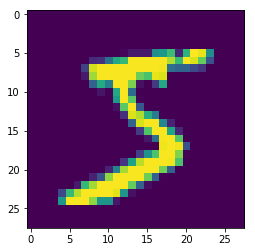

In [11]:
plt.imshow(image)
plt.show()

In [12]:
def show_image(data_matrix, index):
	image=data_matrix[index,1:].reshape((28,28))
	plt.imshow(image)
	plt.show()

In [13]:
data.shape

(60000, 785)

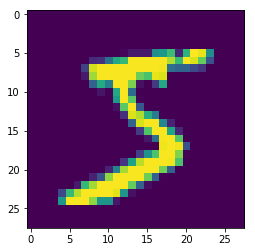

In [14]:
show_image(data, 0)

In [15]:
#create validation set
from sklearn.model_selection import train_test_split
train_data,val_data=train_test_split(data, test_size=0.2, random_state=42)

In [34]:
import numpy as np
from random import shuffle
from sklearn.metrics import mean_squared_error

class Network(object):
    
    def __init__(self, train_data, hidden_layer_neurons_num, epochs, learning_rate = 0.05):
        self.number_of_classes = 10
        self.epochs=epochs
        self.train_data = train_data
        self.learning_rate = learning_rate
        train_data_without_labels = train_data[:,1:]
        self.input_neurons_num = train_data_without_labels.shape[0] \
            if len(train_data_without_labels.shape) == 1 \
            else train_data_without_labels.shape[1]
        self.neurons_num_per_layer = [self.input_neurons_num] + hidden_layer_neurons_num + [self.number_of_classes]
        self.layers_num = len(self.neurons_num_per_layer)
        self.activation_functions = [lambda x: self.sigmoid_function(x)] * (self.layers_num - 2) + \
            [lambda x: self.softmax_function(x)] 
        self.weight_list = [np.random.randn(next_layer_num, current_layer_num) \
                       for (current_layer_num, next_layer_num) in \
                            zip(self.neurons_num_per_layer, self.neurons_num_per_layer[1:])]
        self.bias_list = [np.random.randn(layer_num,1) for layer_num in self.neurons_num_per_layer[1:]]
        
    
    def main(self, batch_size):
        avg_mse=np.zeros(self.epochs) 
        for epoch in range(self.epochs):
            shuffle(self.train_data)
            train_batches = self.create_train_batches(batch_size)
            mse1=self.feed_forward(train_batches)
            avg_mse[epoch]=mse1/self.train_data.shape[0]
        return avg_mse 
                

    #uwaga feedforward można zrobić macierzowo, ale backprop trzeba dla pojedynczych rekordów
    def feed_forward(self, train_batches):
        mse = 0
        for train_batch in train_batches:
            labels = self.one_hot_encoded(train_batch[:, 0:1])
            train_batch_features = train_batch[:, 1:]
            batch_size=train_batch_features.shape[0]
        
            #forward
            grad_w=[0] * (self.layers_num - 1)
            grad_b=[0] * (self.layers_num - 1)
            
            for i in range (len(train_batch)): #rekord
                u = []
                layer_output = [train_batch_features[i,:]]
                for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                    a=np.matmul(w,layer_output[-1])
                    u.append(a.reshape(a.shape[0], 1) + b)
                    layer_output.append(activation_function(u[-1]))
                
                mse+=mean_squared_error(layer_output[-1],labels[:,i].reshape(10,1))
                
                #backprop
                label=labels[:,i].reshape(10,1)
                delta = [(layer_output[-1] - label) * self.softmax_derivative(layer_output[-1], u[-1])] 
                for layer_num in reversed(range(1, self.layers_num-1)):
                    delta.append(np.matmul(self.weight_list[layer_num].T, delta[-1])*\
                                 self.sigmoid_derivative(u[layer_num-1])) 
                delta = list(reversed(delta))
            
                tmp_grad_w = [np.matmul(delta[0], train_batch_features[i,:].reshape(784,1).T)]
                for activ, d, _u in zip(self.activation_functions, delta[1:], u):
                    tmp_grad_w.append(np.matmul(d,activ(_u).T))
                    
                grad_w = [a + b for a, b in zip(grad_w, tmp_grad_w)]
                grad_b= [a + b for a, b in zip(delta, grad_b)]
                
            new_weight_list = [w - (self.learning_rate * gw / batch_size) \
                               for w, gw in zip(self.weight_list, grad_w)]
            self.weight_list = new_weight_list
            
            new_bias_list = [ b - (self.learning_rate * gb / batch_size) \
                             for b, gb in zip(self.bias_list, grad_b)]
            self.bias_list = new_bias_list
        return mse
    
    def predict(self, test_batch):
        labels = self.one_hot_encoded(test_batch[:, 0:1])
        test_batch_features = test_batch[:, 1:]
        batch_size=test_batch_features.shape[0]
        res = []
        
        for i in range(len(test_batch)):
            layer_output = test_batch_features[i,:]
            for activation_function, w, b in zip(self.activation_functions, \
                                                 self.weight_list, \
                                                 self.bias_list):
                a = np.matmul(w,layer_output)
                u = a.reshape(a.shape[0], 1) + b
                layer_output = activation_function(u)
    
            res.append(layer_output)
            print("label: {0}, wanted: {1}".format(np.argmax(layer_output), test_batch[i, 0:1]))
        return res
            
    def softmax_derivative(self, probabilities, u):
        diff_output=np.zeros([self.number_of_classes, self.number_of_classes])
        for row in range (diff_output.shape[0]):
            for col in range (diff_output.shape[1]):
                if (col==row):
                    diff_output[row,col]=probabilities[row,0]*(1-probabilities[col,0])
                else:
                    diff_output[row,col]=-probabilities[row,0]*probabilities[col,0]
        return np.matmul(diff_output,u)
                             
    def sigmoid_derivative(self, u):
        sigmoid_value = self.sigmoid_function(u)
        diff_output=sigmoid_value*(1-sigmoid_value)
        return diff_output
        
    def tanh_derivative(self, u):
        diff_output=1-(u)^2
        return diff_output
         
    def create_train_batches(self, batch_size):
        rows_num = self.train_data.shape[0]
        n = int(np.ceil(rows_num / batch_size))
        return [self.train_data[(i * batch_size):min((i + 1) * batch_size, rows_num)] for i in range(n)]
    
    def one_hot_encoded(self, train_labels):
        train_labels = train_labels.astype(int)
        res = np.zeros((self.number_of_classes, train_labels.shape[0]))
        res[train_labels, np.arange(res.shape[1])] = 1
        return res
        
    def sigmoid_function(self, x):
        return 1 / (1 + np.exp(-x))
    
    def softmax_function(self, x):
        return np.exp(x) / np.sum(np.exp(x)) 
        


In [35]:
net = Network(train_data[1:48000,:], [100, 90, 40], 10)

In [36]:
[matrix.shape for matrix in net.weight_list]

[(100, 784), (90, 100), (40, 90), (10, 40)]

In [37]:
net.input_neurons_num

784

In [38]:
net.bias_list[2].shape

(40, 1)

In [39]:
ms = net.main(128)

In [40]:
net.predict(val_data)

label: 0, wanted: [7.]
label: 5, wanted: [3.]
label: 5, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 5, wanted: [2.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [7.]
label: 0, wanted: [4.]
label: 0, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 5, wanted: [1.]
label: 2, wanted: [7.]
label: 0, wanted: [6.]
label: 5, wanted: [5.]
label: 5, wanted: [3.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 5, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 5, wanted: [2.]
label: 0, w

label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 5, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [4.]
label: 6, wanted: [2.]
label: 0, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 5, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 2, wanted: [8.]
label: 0, wanted: [5.]
label: 5, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 5, wanted: [3.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [2.]
label: 5, wanted: [8.]
label: 0, wanted: [8.]
label: 5, wanted: [1.]
label: 0, wanted: [6.]
label: 0, wanted: [2.]
label: 0, wanted: [8.]
label: 0, wanted: [0.]
label: 5, wanted: [8.]
label: 0, wanted: [0.]
label: 5, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [2.]
label: 0, w

label: 0, wanted: [4.]
label: 0, wanted: [8.]
label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 5, wanted: [1.]
label: 0, wanted: [7.]
label: 5, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 5, wanted: [7.]
label: 0, wanted: [2.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 5, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [5.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 5, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [6.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 5, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 0, w

label: 0, wanted: [1.]
label: 0, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 8, wanted: [6.]
label: 0, wanted: [7.]
label: 5, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 5, wanted: [2.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [1.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [9.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [1.]
label: 8, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, w

label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [1.]
label: 5, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [5.]
label: 5, wanted: [9.]
label: 8, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 5, wanted: [2.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [8.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 5, wanted: [8.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 5, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [1.]
label: 5, wanted: [2.]
label: 0, wanted: [3.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 5, wanted: [2.]
label: 5, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [6.]
label: 5, wanted: [7.]
label: 5, wanted: [0.]
label: 0, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, w

label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 5, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 5, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [2.]
label: 0, wanted: [5.]
label: 5, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 5, wanted: [0.]
label: 0, wanted: [0.]
label: 5, wanted: [8.]
label: 5, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [2.]
label: 0, wanted: [8.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 5, wanted: [8.]
label: 5, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, w

label: 0, wanted: [4.]
label: 5, wanted: [1.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [3.]
label: 0, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [4.]
label: 5, wanted: [2.]
label: 0, wanted: [5.]
label: 5, wanted: [2.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 5, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 5, wanted: [8.]
label: 5, wanted: [5.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 0, wanted: [4.]
label: 0, wanted: [3.]
label: 5, wanted: [9.]
label: 0, w

label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [0.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 5, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 5, wanted: [7.]
label: 0, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [6.]
label: 5, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 5, wanted: [7.]
label: 5, wanted: [5.]
label: 0, wanted: [5.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 5, wanted: [2.]
label: 5, wanted: [4.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 5, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 5, wanted: [1.]
label: 0, w

label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 5, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 5, wanted: [4.]
label: 5, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 0, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [1.]
label: 5, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [2.]
label: 0, wanted: [5.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 0, w

label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 5, wanted: [1.]
label: 5, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [3.]
label: 8, wanted: [7.]
label: 5, wanted: [1.]
label: 6, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [0.]
label: 0, wanted: [9.]
label: 5, wanted: [8.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 5, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 2, wanted: [8.]
label: 0, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 5, wanted: [1.]
label: 0, w

label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [5.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [9.]
label: 5, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 5, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [1.]
label: 0, wanted: [6.]
label: 5, wanted: [4.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 2, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 5, wanted: [2.]
label: 0, w

label: 0, wanted: [1.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 5, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 5, wanted: [5.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 8, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [4.]
label: 3, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 5, wanted: [1.]
label: 5, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [9.]
label: 5, wanted: [0.]
label: 0, wanted: [5.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 5, wanted: [1.]
label: 0, wanted: [3.]
label: 0, w

label: 0, wanted: [6.]
label: 5, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 5, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 5, wanted: [1.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 5, wanted: [4.]
label: 0, wanted: [0.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 5, wanted: [4.]
label: 0, wanted: [6.]
label: 5, wanted: [1.]
label: 0, wanted: [3.]
label: 5, wanted: [8.]
label: 5, wanted: [1.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 5, wanted: [9.]
label: 0, wanted: [2.]
label: 0, w

label: 0, wanted: [2.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [5.]
label: 0, wanted: [8.]
label: 5, wanted: [3.]
label: 0, wanted: [7.]
label: 5, wanted: [3.]
label: 0, wanted: [6.]
label: 5, wanted: [1.]
label: 5, wanted: [1.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [8.]
label: 0, wanted: [6.]
label: 5, wanted: [0.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [8.]
label: 2, wanted: [6.]
label: 6, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [2.]
label: 5, wanted: [5.]
label: 5, wanted: [9.]
label: 0, wanted: [6.]
label: 0, wanted: [6.]
label: 5, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 5, wanted: [8.]
label: 5, wanted: [5.]
label: 0, wanted: [8.]
label: 8, wanted: [8.]
label: 0, wanted: [7.]
label: 5, wanted: [2.]
label: 0, w

label: 0, wanted: [9.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 0, wanted: [2.]
label: 0, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 5, wanted: [8.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 5, wanted: [8.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 5, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 2, wanted: [0.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [4.]
label: 5, wanted: [3.]
label: 0, wanted: [7.]
label: 0, w

label: 5, wanted: [1.]
label: 0, wanted: [7.]
label: 5, wanted: [3.]
label: 0, wanted: [5.]
label: 0, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 5, wanted: [5.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 0, wanted: [2.]
label: 0, w

label: 0, wanted: [8.]
label: 0, wanted: [8.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [4.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [2.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 0, wanted: [2.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 5, wanted: [1.]
label: 0, wanted: [3.]
label: 5, wanted: [4.]
label: 0, wanted: [2.]
label: 5, wanted: [0.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 5, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 5, wanted: [5.]
label: 0, wanted: [2.]
label: 5, wanted: [8.]
label: 0, wanted: [2.]
label: 8, wanted: [2.]
label: 0, wanted: [4.]
label: 0, w

label: 0, wanted: [6.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [7.]
label: 6, wanted: [7.]
label: 0, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 5, wanted: [5.]
label: 5, wanted: [1.]
label: 5, wanted: [1.]
label: 5, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [4.]
label: 0, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [9.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 6, wanted: [7.]
label: 5, wanted: [8.]
label: 5, wanted: [6.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 5, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 5, wanted: [4.]
label: 5, wanted: [4.]
label: 0, wanted: [4.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 5, w

label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 5, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [4.]
label: 8, wanted: [2.]
label: 0, wanted: [0.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 5, wanted: [8.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 8, wanted: [3.]
label: 0, wanted: [8.]
label: 5, wanted: [2.]
label: 0, wanted: [3.]
label: 5, wanted: [2.]
label: 5, wanted: [1.]
label: 5, wanted: [9.]
label: 0, wanted: [1.]
label: 5, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 0, w

label: 5, wanted: [1.]
label: 0, wanted: [3.]
label: 5, wanted: [2.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 5, wanted: [8.]
label: 0, wanted: [0.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 0, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 5, wanted: [4.]
label: 0, wanted: [5.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [0.]
label: 0, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [9.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 5, wanted: [0.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 5, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 5, wanted: [2.]
label: 0, wanted: [7.]
label: 5, w

label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [8.]
label: 5, wanted: [2.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 3, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 0, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [2.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 5, wanted: [5.]
label: 5, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 5, wanted: [5.]
label: 0, wanted: [2.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [8.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [9.]
label: 5, wanted: [2.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 0, wanted: [3.]
label: 0, wanted: [4.]
label: 0, wanted: [3.]
label: 0, w

label: 0, wanted: [5.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 5, wanted: [3.]
label: 0, wanted: [0.]
label: 5, wanted: [1.]
label: 5, wanted: [1.]
label: 5, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [2.]
label: 0, wanted: [0.]
label: 0, wanted: [1.]
label: 0, wanted: [2.]
label: 0, wanted: [3.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [8.]
label: 0, wanted: [4.]
label: 0, wanted: [0.]
label: 5, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [8.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 0, wanted: [6.]
label: 0, w

label: 0, wanted: [6.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 5, wanted: [3.]
label: 5, wanted: [1.]
label: 5, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 5, wanted: [6.]
label: 0, wanted: [8.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 2, wanted: [4.]
label: 3, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 0, wanted: [1.]
label: 0, wanted: [9.]
label: 0, wanted: [5.]
label: 0, wanted: [6.]
label: 0, wanted: [6.]
label: 0, wanted: [2.]
label: 5, wanted: [1.]
label: 0, wanted: [3.]
label: 0, wanted: [1.]
label: 0, wanted: [6.]
label: 5, wanted: [7.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [0.]
label: 8, wanted: [3.]
label: 0, w

label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 5, wanted: [0.]
label: 5, wanted: [2.]
label: 0, wanted: [2.]
label: 0, wanted: [9.]
label: 0, wanted: [1.]
label: 0, wanted: [6.]
label: 5, wanted: [1.]
label: 0, wanted: [8.]
label: 2, wanted: [0.]
label: 5, wanted: [6.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [2.]
label: 0, wanted: [8.]
label: 5, wanted: [7.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 5, wanted: [8.]
label: 0, wanted: [1.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 5, wanted: [2.]
label: 0, wanted: [1.]
label: 0, wanted: [6.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [6.]
label: 5, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [7.]
label: 0, wanted: [5.]
label: 5, wanted: [1.]
label: 0, wanted: [1.]
label: 5, wanted: [3.]
label: 0, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [9.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, w

label: 0, wanted: [9.]
label: 0, wanted: [7.]
label: 5, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [5.]
label: 0, wanted: [9.]
label: 0, wanted: [8.]
label: 0, wanted: [5.]
label: 0, wanted: [4.]
label: 0, wanted: [5.]
label: 0, wanted: [9.]
label: 5, wanted: [1.]
label: 0, wanted: [4.]
label: 0, wanted: [7.]
label: 0, wanted: [3.]
label: 0, wanted: [8.]
label: 5, wanted: [1.]
label: 0, wanted: [5.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 5, wanted: [8.]
label: 0, wanted: [7.]
label: 0, wanted: [7.]
label: 0, wanted: [4.]
label: 5, wanted: [2.]
label: 0, wanted: [3.]
label: 0, wanted: [3.]
label: 0, wanted: [6.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [0.]
label: 0, wanted: [6.]
label: 0, wanted: [0.]
label: 0, wanted: [4.]
label: 0, wanted: [9.]
label: 0, wanted: [3.]
label: 0, wanted: [7.]
label: 0, wanted: [0.]
label: 0, wanted: [7.]
label: 0, wanted: [1.]
label: 0, wanted: [5.]
label: 0, w

[array([[9.90297684e-01],
        [5.91732071e-05],
        [2.93606703e-03],
        [9.02740092e-04],
        [1.81493976e-07],
        [3.23416780e-04],
        [5.21068025e-03],
        [4.03051826e-05],
        [2.29508560e-04],
        [2.43301460e-07]]), array([[1.57826378e-01],
        [1.44980881e-02],
        [3.67040712e-02],
        [5.09061093e-02],
        [8.96828522e-06],
        [7.23062873e-01],
        [9.40702587e-03],
        [1.57015251e-03],
        [5.98052335e-03],
        [3.58111166e-05]]), array([[2.31527602e-01],
        [1.85202448e-03],
        [7.60530252e-04],
        [7.40617280e-05],
        [1.45936951e-05],
        [7.34859029e-01],
        [2.95467943e-02],
        [1.78365821e-05],
        [1.32886637e-03],
        [1.86607893e-05]]), array([[7.60532202e-01],
        [8.68160476e-04],
        [2.71417811e-03],
        [2.90976376e-04],
        [1.93708064e-06],
        [2.22466175e-01],
        [1.00530669e-02],
        [1.33102986e-05],
        [

In [41]:
len(train_data)

48000

In [42]:
ms

array([1.10107114e-03, 3.49320320e-05, 2.14477137e-05, 1.61714884e-05,
       1.34360840e-05, 1.18120185e-05, 1.07679345e-05, 1.00618287e-05,
       9.56812603e-06, 9.21537658e-06])